<a href="https://colab.research.google.com/github/zSoftwareRepository/MDS-561-46-22SU/blob/main/Autoencoder%20Version%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
seed = 23

import numpy as np
np.random.seed(seed)

from tensorflow.keras.utils import set_random_seed 
set_random_seed(seed)

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import load_model, Model

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

In [2]:
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = tf.keras.Sequential([
                       tf.keras.layers.Dense(20, activation="relu",input_shape=(features,)),
                       tf.keras.layers.Dense(16, activation="relu"),
                       tf.keras.layers.Dense(8, activation="relu"),
                       ])
        self.decoder = tf.keras.Sequential([
                       tf.keras.layers.Dense(16, activation="relu"),
                       tf.keras.layers.Dense(20, activation="relu"),
                       tf.keras.layers.Dense(features, activation="sigmoid")
                       ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def get_config(self):
        base_config = super().get_config()
        return{**base_config, "output_dim" : output_dim, "activation": activation}

In [3]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [55]:
data = pd.read_csv('drive/MyDrive/data/creditcard.csv')

In [56]:
Class = pd.DataFrame(data['Class'],columns=['Class'])

In [57]:
data.drop(['Time', 'Class'], axis=1,inplace=True)

In [58]:
data1  = data[Class['Class']==1].reset_index(drop=True)
class1 = Class[Class['Class']==1].reset_index(drop=True)

In [59]:
folds = pd.DataFrame(np.zeros(data.shape[0]),columns=['fold'])
folds.index = data.index

n_folds = 10

kf = KFold(n_splits=n_folds,random_state=seed,shuffle=True)

for n, (train_index, val_index) in enumerate(kf.split(data)):
    folds.loc[val_index, 'fold'] = int(n)

folds.loc[:,'fold'] = folds.loc[:,'fold'].astype(int)

In [60]:
val_idx = folds[folds['fold'] == 0].index 
holdout = data.iloc[val_idx].reset_index(drop=True).copy()
Class_holdout = Class.iloc[val_idx].reset_index(drop=True).copy()

In [61]:
trn_idx = folds[folds['fold'] != 0].index
data = data.iloc[trn_idx].reset_index(drop=True).copy()
Class = Class.iloc[trn_idx].reset_index(drop=True).copy()

In [62]:
X_train, X_test, y_train, y_test = train_test_split(data, Class, test_size=0.2, random_state=seed)

In [63]:
scaler = MinMaxScaler()
scaler.fit(X_train)
Xn_train = scaler.transform(X_train)
Xn_test  = scaler.transform(X_test)

In [64]:
features = X_train.shape[1]

In [65]:
nc_train = Xn_train[y_train['Class'] == 0]
nc_test  = Xn_test[y_test['Class'] == 0]

In [66]:
an_train = Xn_train[y_train['Class'] == 1]
an_test  = Xn_test[y_test['Class'] == 1]

In [67]:
test = np.concatenate([an_test,nc_test],axis=0)

In [68]:
model = AutoEncoder()

learning_rate = 1e-3

cb_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.4, patience = 2, verbose = 0, min_delta = 0.001, mode = 'min')
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),loss="mae")
history = model.fit(nc_train, nc_train, epochs=100, batch_size=128,
                    validation_data=(nc_test, nc_test),
                    shuffle=True,
                    callbacks=[cb_lr,es],
                    verbose=2)

Epoch 1/100
1600/1600 - 5s - loss: 0.0313 - val_loss: 0.0231 - lr: 0.0010 - 5s/epoch - 3ms/step
Epoch 2/100
1600/1600 - 4s - loss: 0.0227 - val_loss: 0.0227 - lr: 0.0010 - 4s/epoch - 3ms/step
Epoch 3/100
1600/1600 - 4s - loss: 0.0225 - val_loss: 0.0225 - lr: 0.0010 - 4s/epoch - 3ms/step
Epoch 4/100
1600/1600 - 4s - loss: 0.0224 - val_loss: 0.0225 - lr: 4.0000e-04 - 4s/epoch - 3ms/step
Epoch 5/100
1600/1600 - 5s - loss: 0.0224 - val_loss: 0.0225 - lr: 4.0000e-04 - 5s/epoch - 3ms/step
Epoch 6/100
1600/1600 - 4s - loss: 0.0224 - val_loss: 0.0225 - lr: 1.6000e-04 - 4s/epoch - 3ms/step
Epoch 7/100
1600/1600 - 4s - loss: 0.0224 - val_loss: 0.0225 - lr: 1.6000e-04 - 4s/epoch - 3ms/step
Epoch 8/100
1600/1600 - 5s - loss: 0.0224 - val_loss: 0.0225 - lr: 6.4000e-05 - 5s/epoch - 3ms/step
Epoch 9/100
1600/1600 - 4s - loss: 0.0224 - val_loss: 0.0224 - lr: 6.4000e-05 - 4s/epoch - 3ms/step
Epoch 10/100
1600/1600 - 4s - loss: 0.0224 - val_loss: 0.0224 - lr: 2.5600e-05 - 4s/epoch - 3ms/step
Epoch 11/10

In [69]:
#Test data
encoder_out = model.encoder(nc_test).numpy() 
decoder_out = model.decoder(encoder_out).numpy()

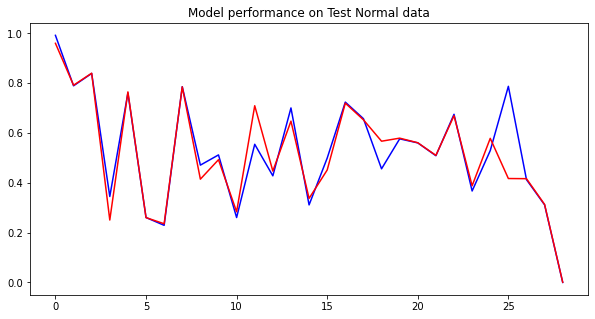

In [100]:
fig = plt.figure(figsize = (10, 5))
plt.plot(nc_test[1], 'b')
plt.plot(decoder_out[1], 'r')
plt.title("Model performance on Test Normal data")
plt.show()

In [71]:
# Train Data
encoder_out = model.encoder(nc_train).numpy() 
decoder_out = model.decoder(encoder_out).numpy()

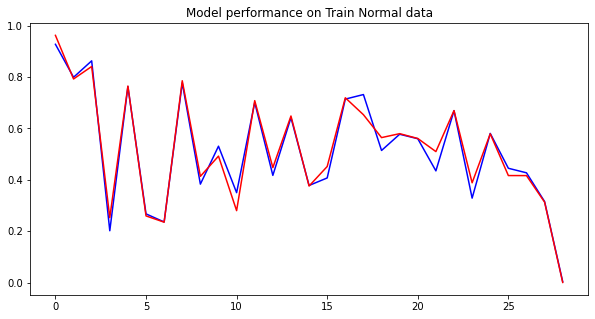

In [72]:
fig = plt.figure(figsize = (10, 5))
plt.plot(nc_train[10], 'b')
plt.plot(decoder_out[10], 'r')
plt.title("Model performance on Train Normal data")
plt.show()

In [73]:
encoder_out_a = model.encoder(an_train).numpy() 
decoder_out_a = model.decoder(encoder_out_a).numpy()

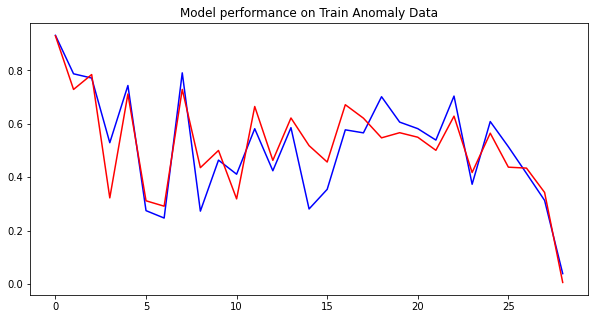

In [101]:
fig = plt.figure(figsize = (10, 5))
plt.plot(an_test[1], 'b')
plt.plot(decoder_out_a[1], 'r')
plt.title("Model performance on Train Anomaly Data")
plt.show()

Detecting anomalies
We will detect anomalies by determining how well our model can reconstruct the input data.

Find MAE loss on training samples.
Find max MAE loss value. This is the worst our model has performed trying to reconstruct a sample. We will make this the threshold for anomaly detection.
If the reconstruction loss for a sample is greater than this threshold value then we can infer that the model is seeing a pattern that it isn't familiar with. We will label this sample as an anomaly.

In [75]:
reconstruction = model.predict(nc_train)
train_loss = tf.keras.losses.mae(reconstruction, nc_train).numpy()

In [76]:
threshold = np.mean(train_loss) + np.std(train_loss)
print(threshold)

0.029944836535729442


In [77]:
preds = tf.math.less(train_loss, threshold)
pred_nc = tf.math.count_nonzero(preds).numpy()

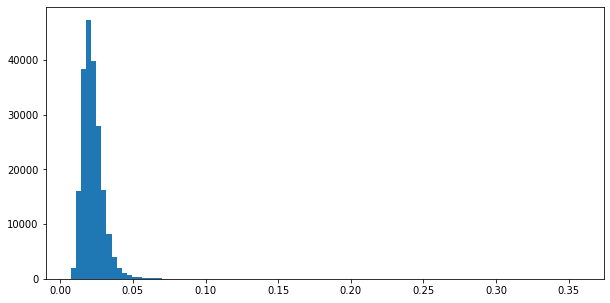

In [78]:
fig = plt.figure(figsize = (10, 5))
x = plt.hist(train_loss, bins=100)

In [79]:
reconstruction_a = model.predict(an_train)
train_loss_a = tf.keras.losses.mae(reconstruction_a, an_train).numpy()

In [80]:
preds_a = tf.math.greater(train_loss_a, threshold)
pred_an = tf.math.count_nonzero(preds_a).numpy()

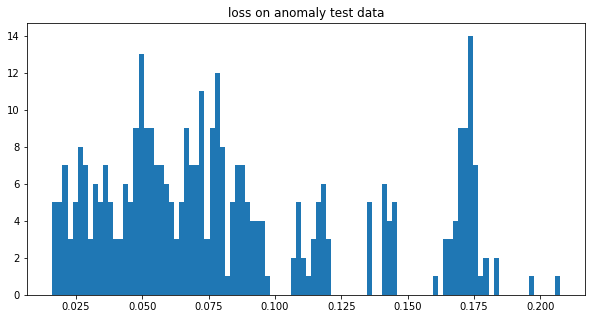

In [81]:
fig = plt.figure(figsize = (10, 5))
plt.hist(train_loss_a, bins=100)
plt.title("loss on anomaly test data")
plt.show()

**Dataset evaluation**

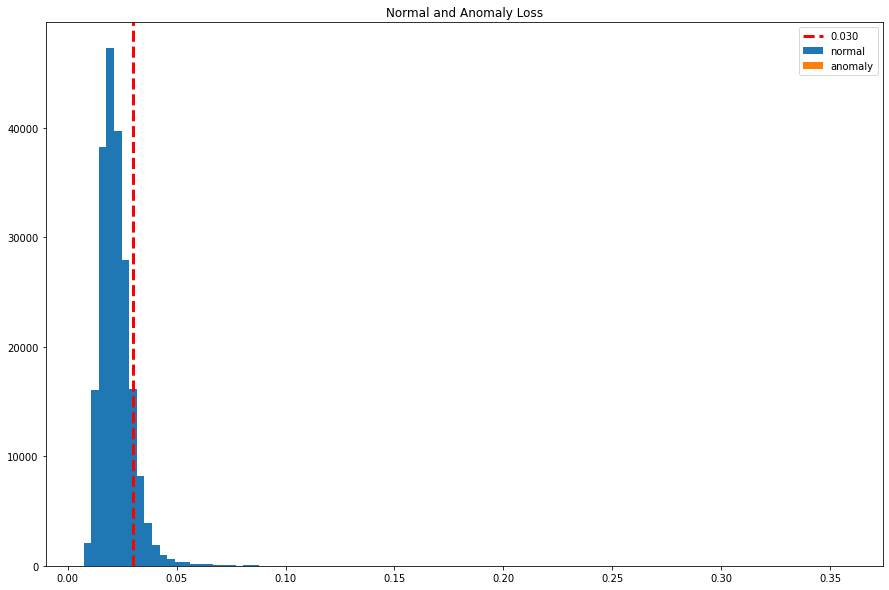

In [82]:
fig = plt.figure(figsize = (15, 10))
plt.hist(train_loss, bins=100, label='normal')
plt.hist(train_loss_a, bins=100, label='anomaly')
plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))
plt.legend(loc='upper right')
plt.title("Normal and Anomaly Loss")
plt.show()

In [84]:
rec_data = scaler.transform(data)

In [85]:
reconstruction_data = model.predict(rec_data)
train_loss_data = tf.keras.losses.mae(rec_data,reconstruction_data).numpy()
preds_data = tf.math.greater(train_loss_data, threshold)

In [86]:
# make predictions for test data and evaluate
predictions = preds_data.numpy()
accuracy = accuracy_score(Class['Class'].values, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 88.03%


In [87]:
# confusion m,atrix
tn, fp, fn, tp = confusion_matrix(Class['Class'].values, predictions).ravel()
print(tn, fp, fn, tp)

225255 30626 47 398


In [88]:
sensitivity = tp/(tp+fn)
print("Sensitivity: %.2f%%" % (sensitivity * 100.0))
specificity = tn/(tn+fp)
print("Specificity: %.2f%%" % (specificity * 100.0))

Sensitivity: 89.44%
Specificity: 88.03%


In [89]:
confusion_matrix(Class['Class'].values, predictions)

array([[225255,  30626],
       [    47,    398]])

**Out of sample results**

In [83]:
holdout = pd.concat([holdout,data1],axis=0)
Class_holdout = pd.concat([Class_holdout,class1],axis=0)

In [91]:
X_holdout  = scaler.transform(holdout)

reconstruction_holdout = model.predict(X_holdout)
loss_holdout = tf.keras.losses.mae(reconstruction_holdout,X_holdout).numpy()
preds_holdout = (loss_holdout >= threshold).astype(np.int32)

In [92]:
# make predictions for test data and evaluate
accuracy = accuracy_score(Class_holdout, preds_holdout)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 87.92%


In [94]:
# confusion m,atrix
tn, fp, fn, tp = confusion_matrix(Class_holdout, preds_holdout).ravel()
print(tn, fp, fn, tp)

24984 3450 51 488


In [95]:
sensitivity = tp/(tp+fn)
print("Sensitivity: %.2f%%" % (sensitivity * 100.0))
specificity = tn/(tn+fp)
print("Specificity: %.2f%%" % (specificity * 100.0))

Sensitivity: 90.54%
Specificity: 87.87%


In [97]:
confusion_matrix(Class_holdout, preds_holdout)

array([[24984,  3450],
       [   51,   488]])